In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json

with open('data.json', 'r') as f:
    df = json.load(f)
print ('main data fields: {}'.format(df.keys()))
for k in df.keys():
    print('{} : {}'.format(k, len(df[k])))
print(type(df['tables'][0]['fp']))

main data fields: dict_keys(['lineage', 'tables', 'joins', 'columns', 'tags'])
lineage : 1172
tables : 2219
joins : 261
columns : 37170
tags : 82
<class 'int'>


In [2]:
# make sure pandas is 0.23.0 up, otherwise DataFrame.dropna() wont work
import pandas as pd
pd.__version__ 


'0.23.1'

In [2]:
# get column names using table_fp, construct a list of dictionary names corpus with 0-1 counts
# get column names count using column_fp, update the above with proper counts
# get table connections by using table_fp, construct #tables x #tables connectivity graph
from collections import Counter, defaultdict
import numpy as np
import math
import re


def get_table_column_data(df):
    table_index_map = {}
    column_table_map = {}
    column_name_map = defaultdict(dict)
    tables = df['tables']
    columns = df['columns']
    print('total have {} tables, {} columns'.format(len(tables), len(columns)))
    table_column_mat = [Counter() for _ in range(len(tables))]
    table_fp = [0 for _ in range(len(tables))]
    for i, crt_table in enumerate(tables):
        table_index_map[crt_table['fp']] = i
        table_fp[i] = crt_table['fp']
        
    for i, crt_column in enumerate(columns):
        table_idx = table_index_map[crt_column['table_fp']]
        column_table_map[crt_column['fp']] = table_idx
        table_column_mat[table_idx][crt_column['fp']] += 1
        for info in ['title', 'schema_name', 'datasource_name', 'table_name', 'description', 'name']:
            column_name_map[crt_column['fp']][info] = crt_column[info]
    
    for i, table in enumerate(table_column_mat):
        if len(table) == 0:
            print('table {} dont have any column'.format(i))
            print('fp {}'.format(table_fp[i]))
    
    return table_column_mat, column_table_map, table_index_map, column_name_map, table_fp


def update_column_count_with_joins(df, table_column_mat, column_table_map):
    print('update column counts with joins')
    joins = df['joins']
    print('total have {} joins'.format(len(joins)))
    
    for i, crt_join in enumerate(joins):
        count = crt_join['num_occurrences']
        for column_fp in crt_join['column_fps']:
            if column_fp not in column_table_map:
                print("column {} not in any table, skipping".format(column_fp))
                continue
                
            table_idx = column_table_map[column_fp]
            assert column_fp in table_column_mat[table_idx],(
            "This column should have already be in the table, table idx: {}, column id: {}".format(
            table_idx, column_fp))
            table_column_mat[table_idx][column_fp] += 1
    return table_column_mat


def preproc_text(text, replace_underscore):
    if replace_underscore:
        text = text.replace("_", " ")
    # replace digits among strings with space
    text = re.sub(r'[0-9]',' ', text)
    
    # Replace all runs of whitespace with space
    text = re.sub(r"\s+", ' ', text)
    return text

def create_corpus_from_table_column_mat(df,
                                        column_name_map, 
                                        table_column_mat,
                                        replace_underscore=False,
                                       use_title=False,
                                       use_schema_name=False,
                                       use_datasource_name=False,
                                       use_description=False):
    corpus = []
    for i, table in enumerate(table_column_mat):
        df_table = df['tables']
        text = [preproc_text(" ".join([df_table[i]['name'], 
                                      df_table[i]['title'],
                                      df_table[i]['datasource_name'],
                                      df_table[i]['schema_name']]), replace_underscore)]
            
        for column_fp, column_cnt in table.items():
            # table_name and name is the default text
            assert column_fp in column_name_map, (
            "column_fp: {} should be in column_name_map".format(column_fp))
                       
            content = column_name_map[column_fp]['name']
            proc_text = preproc_text(content, replace_underscore)
            text.append(" ".join([proc_text] * column_cnt)) 
            
            if use_title:
                content = column_name_map[column_fp]['title']
                proc_text = preproc_text(content, replace_underscore)
                if len(proc_text) > 0:
                    text.append(" ".join([proc_text] * column_cnt))

            if use_schema_name:
                content = column_name_map[column_fp]['schema_name']
                proc_text = preproc_text(content, replace_underscore)
                if len(proc_text) > 0:
                    text.append(" ".join([proc_text] * column_cnt))

            if use_datasource_name:
                content = column_name_map[column_fp]['datasource_name']
                proc_text = preproc_text(content, replace_underscore)
                if len(proc_text) > 0:
                    text.append(" ".join([proc_text] * column_cnt))

            if use_description:
                content = column_name_map[column_fp]['description']
                proc_text = preproc_text(content, replace_underscore)
                if len(proc_text) > 0:
                    text.append(" ".join([proc_text] * column_cnt))

        
        corpus.append(" ".join(text))

    
    return corpus


def get_connect_matrix(fp, table_index_map):
    connect_mat = np.zeros((len(fp['tables']), len(fp['tables'])))
    lineage = fp['lineage']
    count = 0
    for source, target in lineage:
        for s in source:
            if s in table_index_map:
                s_table_idx = table_index_map[s]
            else:
                print('{} not in, skipping'.format(s))
                count += 1
                continue
                
            for t in target:
                if t in table_index_map:
                    t_table_idx = table_index_map[t]
                else:
                    print('{} not in, skipping'.format(s))
                    count += 1
                    continue
                connect_mat[s_table_idx, t_table_idx] += 1
    print ('There are {} data tables not in any lineage'.format(count))
    return connect_mat


def write_corpus(corpus, table_fp, file):
    with open(file, 'w') as f:
        f.write('fp,text\n')
        for i, text in enumerate(corpus):
            f.write("{},{}\n".format(table_fp[i],text))
            
def load_corpus(file):
    with open(file, 'r') as f:
        corpus = []
        for i, line in enumerate(f):
            if i > 0:
                fp, text = line.split(",", maxsplit=1)
                corpus.append(text)
    return corpus
                           

In [4]:
# get original data without using counts, use as much info as possible
table_column_mat, column_table_map, table_index_map, column_name_map, table_fp = get_table_column_data(df)

corpus = create_corpus_from_table_column_mat(df,
                                        column_name_map, 
                                        table_column_mat,
                                        replace_underscore=True,
                                       use_title=True,
                                       use_schema_name=True,
                                       use_datasource_name=True,
                                       use_description=False)

import os
if not os.path.exists("./new_corpus_v2"):
    os.makedirs("./new_corpus_v2")
                      
write_corpus(corpus, table_fp, "./new_corpus_v2/new_corpus_no_count.csv")



total have 2219 tables, 37170 columns
table 562 dont have any column
fp 7139994167853741694
table 612 dont have any column
fp 2914765952205003720
table 613 dont have any column
fp 5927232006923493986
table 614 dont have any column
fp 6256686944218843617
table 618 dont have any column
fp 6006868953247260762
table 620 dont have any column
fp 273645577075415203
table 1170 dont have any column
fp 2416231187737008277
table 1173 dont have any column
fp 6476772536142316289


In [5]:
# get data taking account of join
table_column_mat, column_table_map, table_index_map, column_name_map, table_fp = get_table_column_data(df)
table_column_mat = update_column_count_with_joins(df, table_column_mat, column_table_map)
for use_title in [True, False]:
    for use_schema in [True, False]:
        for use_datasource in [True, False]:
            for use_description in [True, False]:

                corpus = create_corpus_from_table_column_mat(df,
                                                             column_name_map, 
                                                        table_column_mat,
                                                        replace_underscore=True,
                                                       use_title=use_title,
                                                       use_schema_name=use_schema,
                                                       use_datasource_name=use_datasource,
                                                       use_description=use_description)
                write_corpus(corpus, table_fp, 
                             "./new_corpus_v2/new_corpus_join_counts_title_{}_schema_{}_datasource_{}_desc_{}.csv".format(
                use_title, use_schema, use_datasource, use_description))
        

total have 2219 tables, 37170 columns
table 562 dont have any column
fp 7139994167853741694
table 612 dont have any column
fp 2914765952205003720
table 613 dont have any column
fp 5927232006923493986
table 614 dont have any column
fp 6256686944218843617
table 618 dont have any column
fp 6006868953247260762
table 620 dont have any column
fp 273645577075415203
table 1170 dont have any column
fp 2416231187737008277
table 1173 dont have any column
fp 6476772536142316289
update column counts with joins
total have 261 joins
column 3173569903659010075 not in any table, skipping
column 3173569903659010075 not in any table, skipping
column 3173569903659010075 not in any table, skipping
column 3173569903659010075 not in any table, skipping
column 3284979923362687227 not in any table, skipping
column 3284979923362687227 not in any table, skipping
column 7775378868328955312 not in any table, skipping
column 7775378868328955312 not in any table, skipping
column 3173569903659010075 not in any table,


# Cluster model selection starts here. 
## - SpectralClustering only used to connectivity matrix generated from lineage data. 
## - K-means, GMM, as well as hierachical clustering are applied to the results generated from LDA. Note that spectral clustering and hierachical clustering only applied to whole dataset (train/eva split wont work).
## - Usefull source for clustering algorithms http://scikit-learn.org/stable/modules/clustering.html

In [6]:
from sklearn.cluster import SpectralClustering, KMeans, AgglomerativeClustering 
from sklearn.mixture import BayesianGaussianMixture
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score
import pandas as pd

best_config = {}
best_config['file'] = './new_corpus_v2/new_corpus_join_counts_title_False_schema_False_datasource_False_desc_False.csv'
best_config['max_df'] = 0.5
best_config['n_topics'] = 10
best_config['max_iter'] = 500
    
#generate doc_topic_matrix from best config and lda modeling
def bestLDA(best_config, n_topics = 10): # 10 is the best number of topics selected based on LDA likelihood from data
    # only explore topics, as the rest are explored before
    
    corpus = load_corpus(best_config['file'])
    corpus = np.asarray(corpus)
    feat_ext = CountVectorizer(max_df = best_config['max_df'], 
                             stop_words = 'english',
                             strip_accents = 'ascii')
    lda = LatentDirichletAllocation(n_components=n_topics, 
                                    learning_method='batch',
                                    n_jobs=-1,
                                    max_iter=best_config['max_iter'],
                                    evaluate_every=5,
                                   random_state = 1)
    return feat_ext, lda

## The following cell uses the provided lineage as affinity matrix for spectral clustering. Note that spectral clustering can only work on full graph level, which means there is no train and test split.

In [7]:
#generate connectivity matrics for spectral clustering
connection_mat = get_connect_matrix(df, table_index_map)

# make it symmetric, as the original one is directed
connection_mat += connection_mat.T

# number of clusteres to do grid search on
n_clusters_grid = list(range(6,21,2))
# number of topics to explore, the best according to data is 10, but we would like to explore a bit more
n_topics_grid = [10, 15, 20]

# add some values for zeros
eps = 1e-1
connection_mat += eps

best_spectral_score = -1
best_spectral_ntopics = 0
best_spectral_nclusteres = 0

for n_topics in n_topics_grid:
    # train and predict spectual model seperately
    feat_ext, lda = bestLDA(best_config, n_topics = n_topics)
    data = feat_ext.fit_transform(corpus)
    doc_topic_matrix = lda.fit_transform(data)

    for n_c in n_clusters_grid:
        model = SpectralClustering(n_clusters=n_c, affinity='precomputed')    
        labels = model.fit_predict(connection_mat)
        sil_score = silhouette_score(doc_topic_matrix, labels)
        print ('silhouette_score for spectral cluster with {} topics: {}'.format(n_topics, sil_score))
        if sil_score > best_spectral_score:
            best_spectral_score = sil_score
            best_spectral_ntopics = n_topics
            best_spectral_nclusters = n_c

print('Best config for spectral clustering: topics: {}, clusters: {}, score: {}'.format(best_spectral_ntopics, best_spectral_nclusters, best_spectral_score))

958354375620957334 not in, skipping
2282691621237527021 not in, skipping
3155553374805852254 not in, skipping
8663790040248980261 not in, skipping
8663790040248980261 not in, skipping
1419348097140043726 not in, skipping
4842380598070760191 not in, skipping
146218568532503109 not in, skipping
146218568532503109 not in, skipping
5704433936627619337 not in, skipping
5704433936627619337 not in, skipping
5704433936627619337 not in, skipping
3065945667226800528 not in, skipping
8009333911104211857 not in, skipping
7493732858998363667 not in, skipping
1545422551088500166 not in, skipping
7493732858998363667 not in, skipping
601670975264639822 not in, skipping
7209884823120927863 not in, skipping
7493732858998363667 not in, skipping
3065945667226800528 not in, skipping
8009333911104211857 not in, skipping
3065945667226800528 not in, skipping
8009333911104211857 not in, skipping
7493732858998363667 not in, skipping
1545422551088500166 not in, skipping
7493732858998363667 not in, skipping
60167

4608742283445209087 not in, skipping
5223074499562926724 not in, skipping
6551792618761793934 not in, skipping
7161566437012276440 not in, skipping
8824379247102353233 not in, skipping
9149621742813471887 not in, skipping
89517095656009759 not in, skipping
900336618089584600 not in, skipping
1391017599223941912 not in, skipping
3828151002226383187 not in, skipping
7888651207983768270 not in, skipping
749083059301555122 not in, skipping
1958318032832843944 not in, skipping
3604560816612274360 not in, skipping
4608742283445209087 not in, skipping
5192142419732934287 not in, skipping
6551792618761793934 not in, skipping
6657013177148671674 not in, skipping
7161566437012276440 not in, skipping
7717887294149845718 not in, skipping
8824379247102353233 not in, skipping
7505494608336059944 not in, skipping
8633379380373941410 not in, skipping
89517095656009759 not in, skipping
117888423842741264 not in, skipping
900336618089584600 not in, skipping
2181425926980263519 not in, skipping
399017900

/home/sophia/anaconda3/lib/python3.6/site-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)


silhouette_score for spectral cluster with 10 topics: -0.20786033287785483
silhouette_score for spectral cluster with 10 topics: -0.25693133414078845
silhouette_score for spectral cluster with 10 topics: -0.26924715674984584
silhouette_score for spectral cluster with 10 topics: -0.2950297557961077
silhouette_score for spectral cluster with 10 topics: -0.29410865431713995
silhouette_score for spectral cluster with 10 topics: -0.36040356320611044
silhouette_score for spectral cluster with 10 topics: -0.3616026173025177
silhouette_score for spectral cluster with 10 topics: -0.44253764661028977
silhouette_score for spectral cluster with 15 topics: -0.18367859600904443
silhouette_score for spectral cluster with 15 topics: -0.19707646836001758
silhouette_score for spectral cluster with 15 topics: -0.19861618573651102
silhouette_score for spectral cluster with 15 topics: -0.20362592793116954
silhouette_score for spectral cluster with 15 topics: -0.21935826826638344
silhouette_score for spectr

## The following two cells do model selection for clustering algorithms. Note that both spectral clustering and  agglomerative clustering do not have train/test split.

In [7]:

# model selection
def eval_clustering(cluster_algo, feat_ext, lda,
                    train_data, test_data, n_clusters):
    feat_ext.fit(train_data)
    train_tf = feat_ext.transform(train_data)
    test_tf = feat_ext.transform(test_data)
    lda.fit(train_tf)
    train_topics_vec = lda.transform(train_tf)
    test_topics_vec = lda.transform(test_tf)
    
    if cluster_algo == BayesianGaussianMixture:
        model = cluster_algo(n_components=n_clusters)
    else:
        model = cluster_algo(n_clusters=n_clusters)
        
    if cluster_algo in [SpectralClustering, AgglomerativeClustering]:
        cluster_id = model.fit_predict(np.vstack((train_topics_vec, test_topics_vec)))
        cluster_id = cluster_id[train_topics_vec.shape[0]:] # only use the test part
    else:
        model.fit(train_topics_vec)
        cluster_id = model.predict(test_topics_vec)
    return silhouette_score(test_topics_vec, cluster_id)

def cluster_model_selection(corpus, best_config, cluster_algo, n_clusters, n_topics):
    
    kf = KFold(n_splits=5, shuffle=True, random_state=201806)
    best_score = -float('inf')
    silhouette_score = []
    for n_t in n_topics:
        feat_ext, lda = bestLDA(best_config, n_topics = n_t)
        for n_c in n_clusters:
            score = []
            print('Cross Validating ...')
            for train_idx, eva_idx in kf.split(corpus):
                score.append(eval_clustering(
                                    cluster_algo=cluster_algo, 
                                    feat_ext=feat_ext, 
                                    lda=lda,
                                    train_data=corpus[train_idx], 
                                    test_data=corpus[eva_idx],
                                    n_clusters=n_c))
            silhouette_score.append(np.mean(score))
            if np.mean(score) > best_score:
                best_score = np.mean(score)
                print("** Best score so far: {:.4f}".format(best_score))
                print("Model: {} with {} clusters".format(cluster_algo, n_c))
    return silhouette_score

def plot_result(scores, n_clusters, n_topics, title):
    fig = plt.figure(figsize=(12, 3), dpi = 320)
    plt.title(title)
    
    for c, n_t in enumerate(n_topics):  
        plt.subplot(1, len(n_topics)+1, c+1)
        plt.xlabel("number of clusters", fontsize = 10)
        plt.ylabel("Silhouette score",  fontsize = 10)
        plt.plot(range(len(n_clusters)), scores[c*len(n_clusters):(c+1)*len(n_clusters)])
        plt.xticks(np.arange(len(n_clusters)), n_clusters)
        plt.title("{} topics".format(n_t), fontsize = 12)
        plt.grid(True)
        plt.ylim(min(scores), max(scores))
        
    plt.tight_layout()
    plt.show()

In [8]:
# read in train test data
corpus = load_corpus(best_config['file'])
corpus = np.asarray(corpus)

table_w_tags = pd.read_csv('table_w_tags.csv')
table_df_text = pd.read_csv('table_df_text.csv',dtype = {'fp': str})
table_processed = pd.read_csv(best_config['file'], dtype={'fp':str})
table_w_tags = table_w_tags.join(table_df_text.set_index('id')['fp'].astype('str'), on = 'table_id')
table_w_tags = table_w_tags.dropna()
table_w_tags = table_w_tags.join(table_processed.set_index('fp')['text'].astype('str'), on='fp')
table_w_tags['table_id'] = table_w_tags['table_id'].astype(str)
table_w_tags['fp'] = table_w_tags['fp'].astype(str)
table_fp = table_df_text['fp'].tolist()

test_index = []
for f in table_w_tags['fp']:
    index_in_table = table_fp.index(f)
    test_index.append(index_in_table)

train_index = []
for i in range(len(table_fp)):
    if i not in test_index:
        train_index.append(i)
train_index = np.asarray(train_index, dtype=np.int32)
test_index = np.asarray(test_index, dtype=np.int32)
corpus_train = corpus[train_index]
corpus_test = np.asarray(table_w_tags['text'])


print ('there is {} samples, and {} test samples'.format(len(corpus_train), len(corpus_test)))

there is 2174 samples, and 45 test samples


In [10]:
print('starting model selection')

# number of clusteres to do grid search on
n_clusters_grid = list(range(6,21,2))
# number of topics to explore, the best according to data is 10, but we would like to explore a bit more
n_topics_grid = [10, 15, 20]
best_score = -1
best_algo = ""
all_scores = []
for algo in [KMeans, BayesianGaussianMixture, SpectralClustering, AgglomerativeClustering]:
    print('Current model {}'.format(algo))
    scores = cluster_model_selection(corpus_train, best_config, algo, n_clusters_grid, n_topics_grid)
    crt_best_score = max(scores)
    all_scores.append(scores)
    print('Best score from {}: {}'.format(algo, crt_best_score))
    if crt_best_score > best_score:
        best_score = crt_best_score
        best_algo = algo

print('Best score {} using {}'.format(best_score, best_algo))

starting model selection
Current model <class 'sklearn.cluster.k_means_.KMeans'>
Cross Validating ...
** Best score so far: 0.4888
Model: <class 'sklearn.cluster.k_means_.KMeans'> with 6 clusters
Cross Validating ...
** Best score so far: 0.5442
Model: <class 'sklearn.cluster.k_means_.KMeans'> with 8 clusters
Cross Validating ...
** Best score so far: 0.5692
Model: <class 'sklearn.cluster.k_means_.KMeans'> with 10 clusters
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Best score from <class 'sklearn.cluster.k_means_.KMeans'>: 0.5691563828478181
Current model <class 'sklearn.mixture.bayesian_mixture

/home/sophia/anaconda3/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Cross Validating ...
** Best score so far: 0.2384
Model: <class 'sklearn.mixture.bayesian_mixture.BayesianGaussianMixture'> with 18 clusters
Cross Validating ...
** Best score so far: 0.2528
Model: <class 'sklearn.mixture.bayesian_mixture.BayesianGaussianMixture'> with 20 clusters
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Best score from <class 'sklearn.mixture.bayesian_mixture.BayesianGaussianMixture'>: 0.25281917240887386
Current model <class 'sklearn.cluster.spectral.SpectralClustering'>
Cross Validating ...


/home/sophia/anaconda3/lib/python3.6/site-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)


** Best score so far: 0.4960
Model: <class 'sklearn.cluster.spectral.SpectralClustering'> with 6 clusters
Cross Validating ...
** Best score so far: 0.5431
Model: <class 'sklearn.cluster.spectral.SpectralClustering'> with 8 clusters
Cross Validating ...
** Best score so far: 0.5682
Model: <class 'sklearn.cluster.spectral.SpectralClustering'> with 10 clusters
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Cross Validating ...
Best score from <class 'sklearn.cluster.spectral.SpectralClustering'>: 0.5682411298301282
Current model <class 'sklearn.cluster.hierarchical.AgglomerativeClustering'>
Cross Validating ...
** Best sc

In [ ]:
#algos = ['KMeans', 'GMM', 'Spectral', 'Agglo']
#for scores, algo in zip(all_scores, algos):
#    plot_result(scores, n_clusters_grid, n_topics_grid, algo)

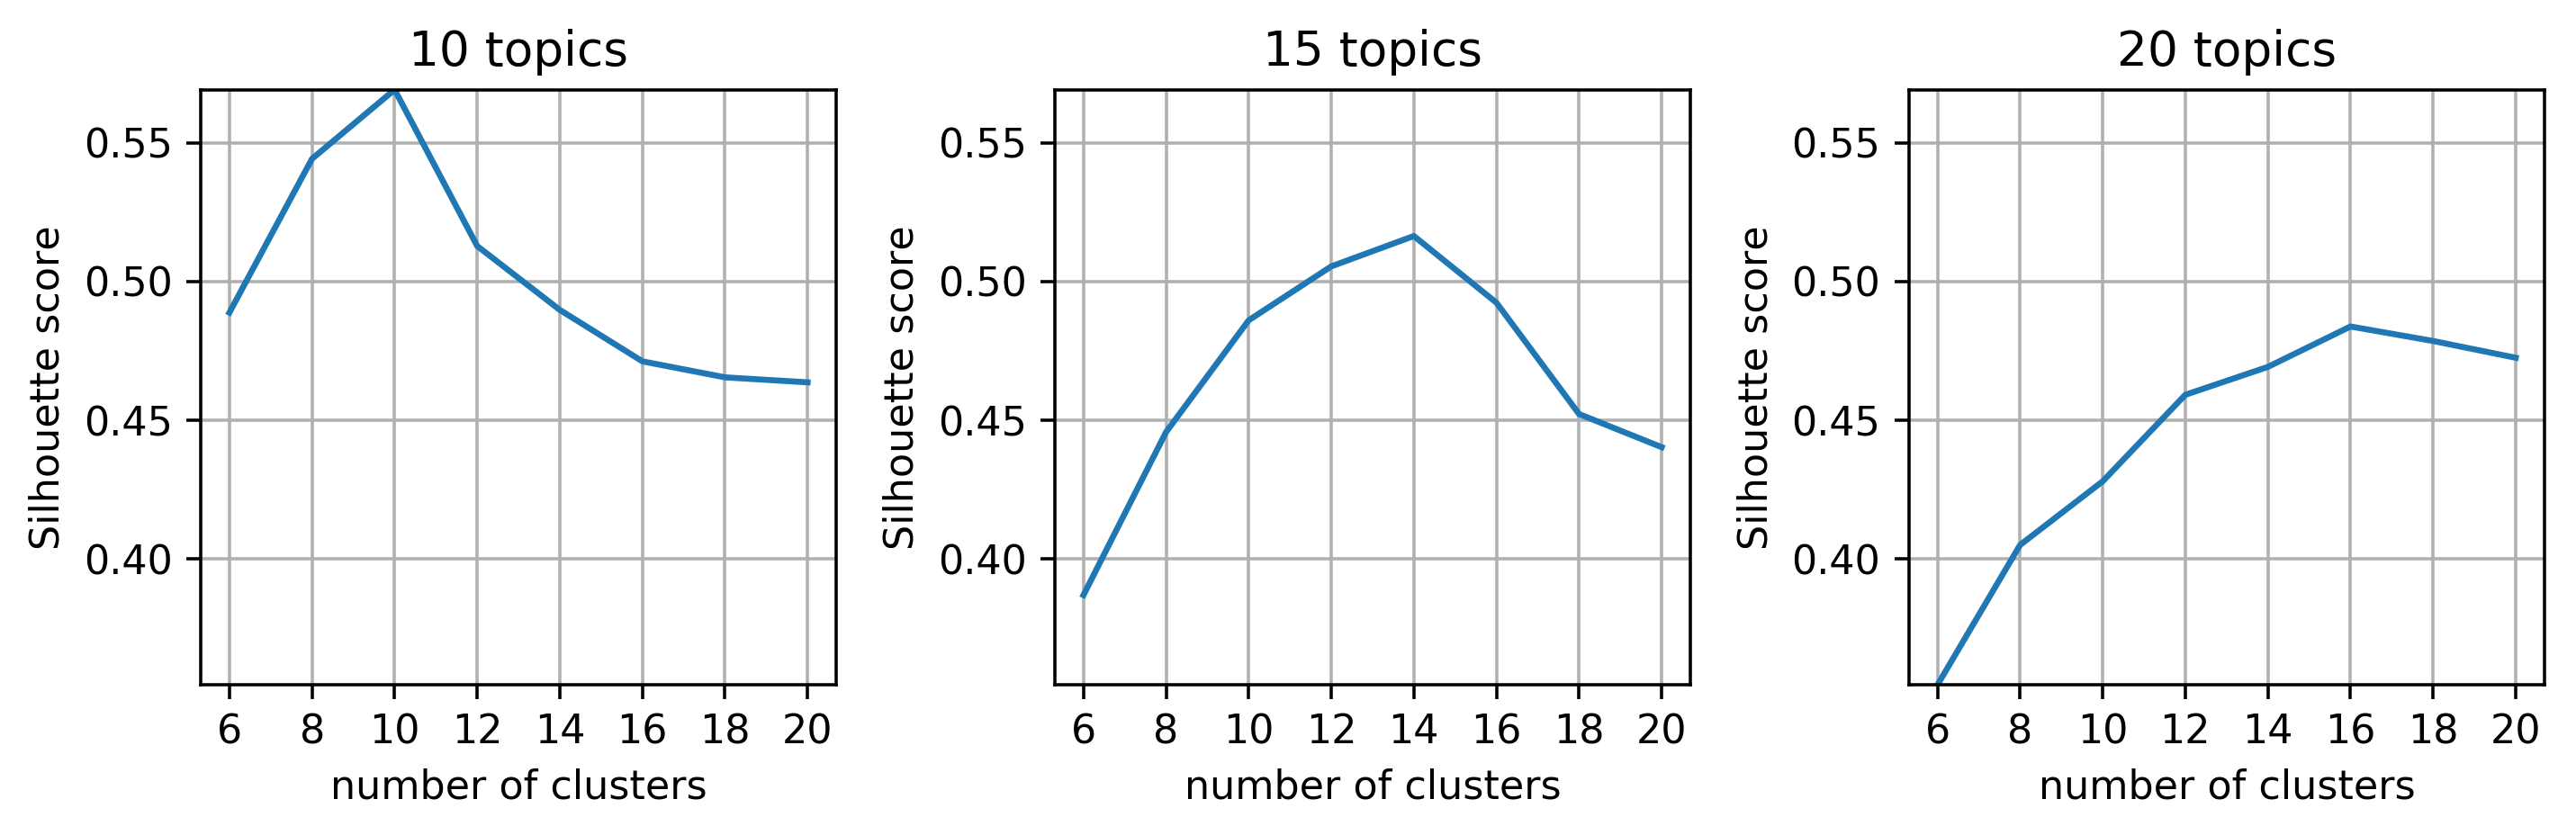

In [11]:
plot_result(all_scores[0], n_clusters_grid, n_topics_grid, 'KMeans')

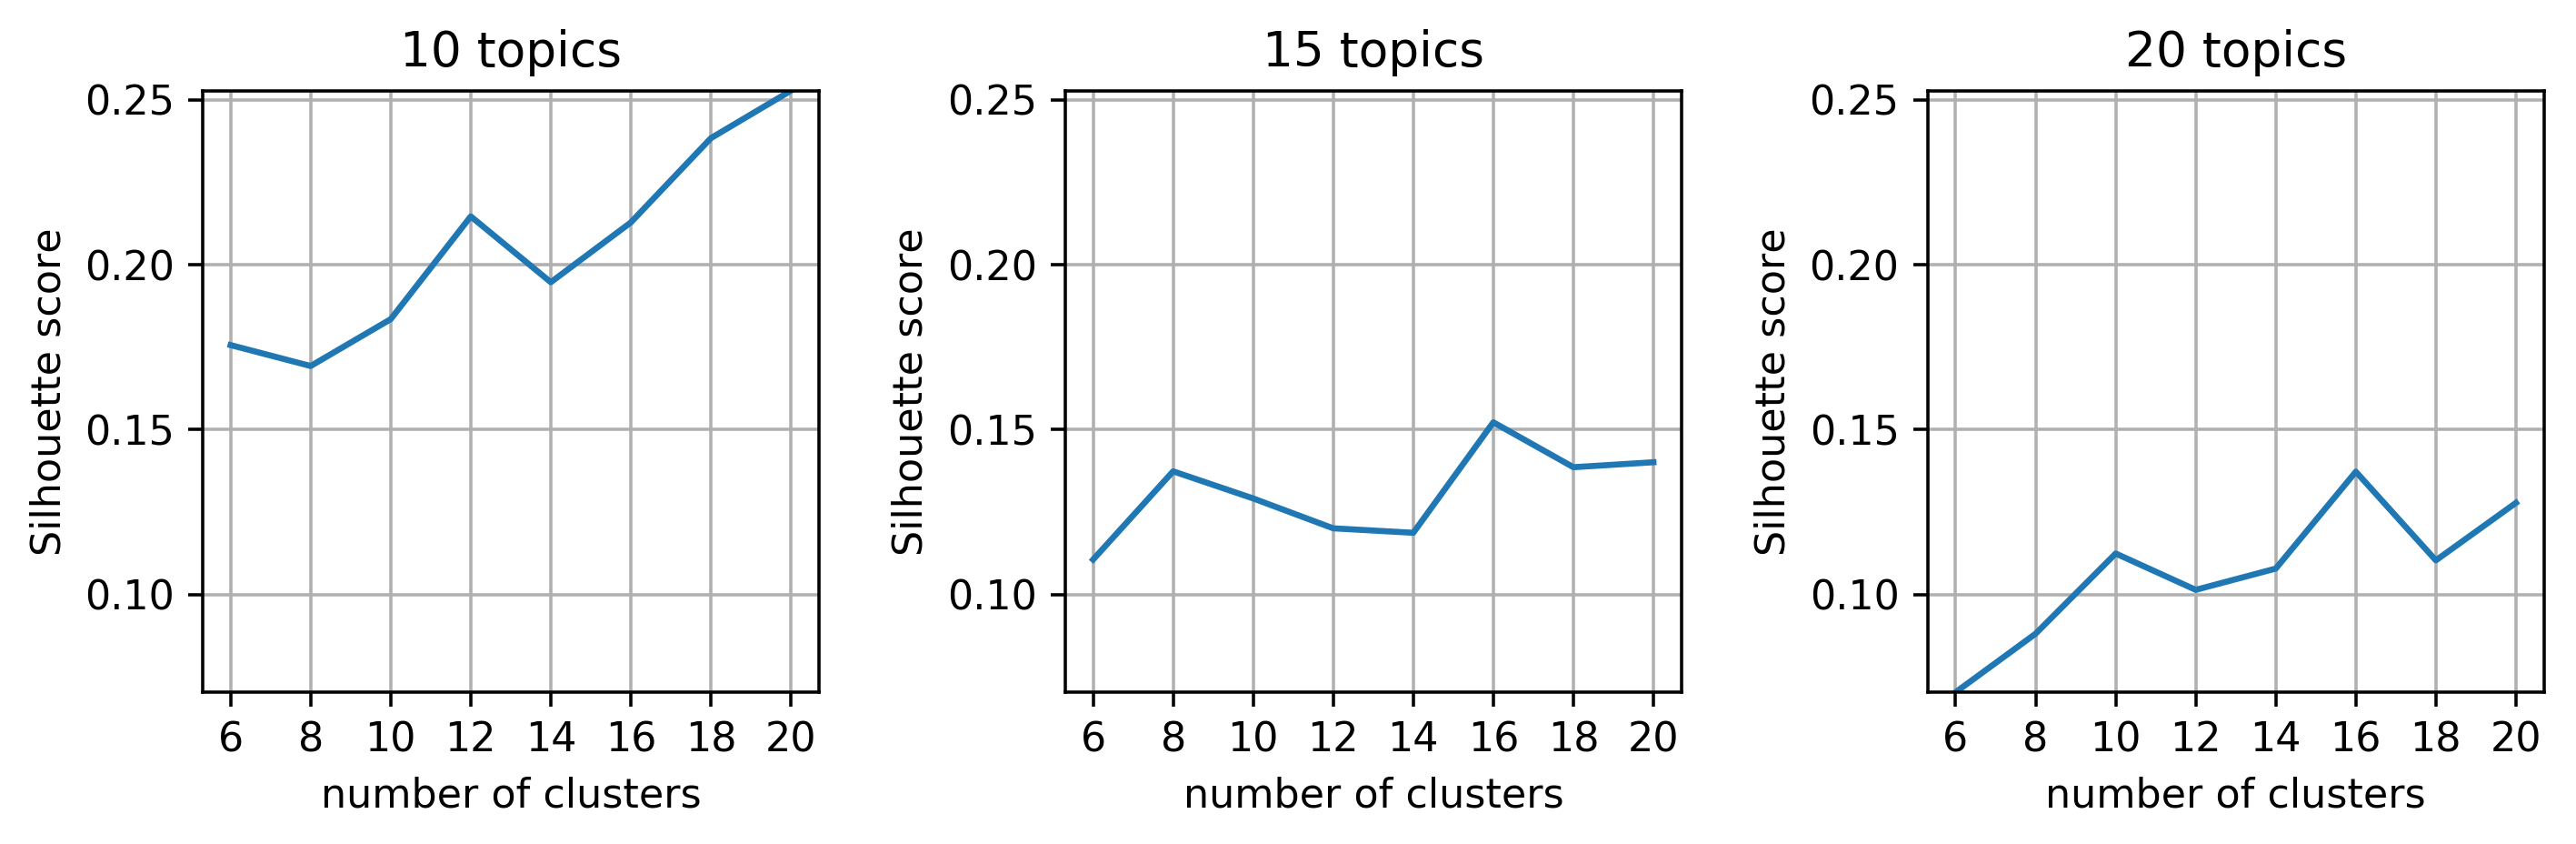

In [12]:
plot_result(all_scores[1], n_clusters_grid, n_topics_grid, 'GMM')

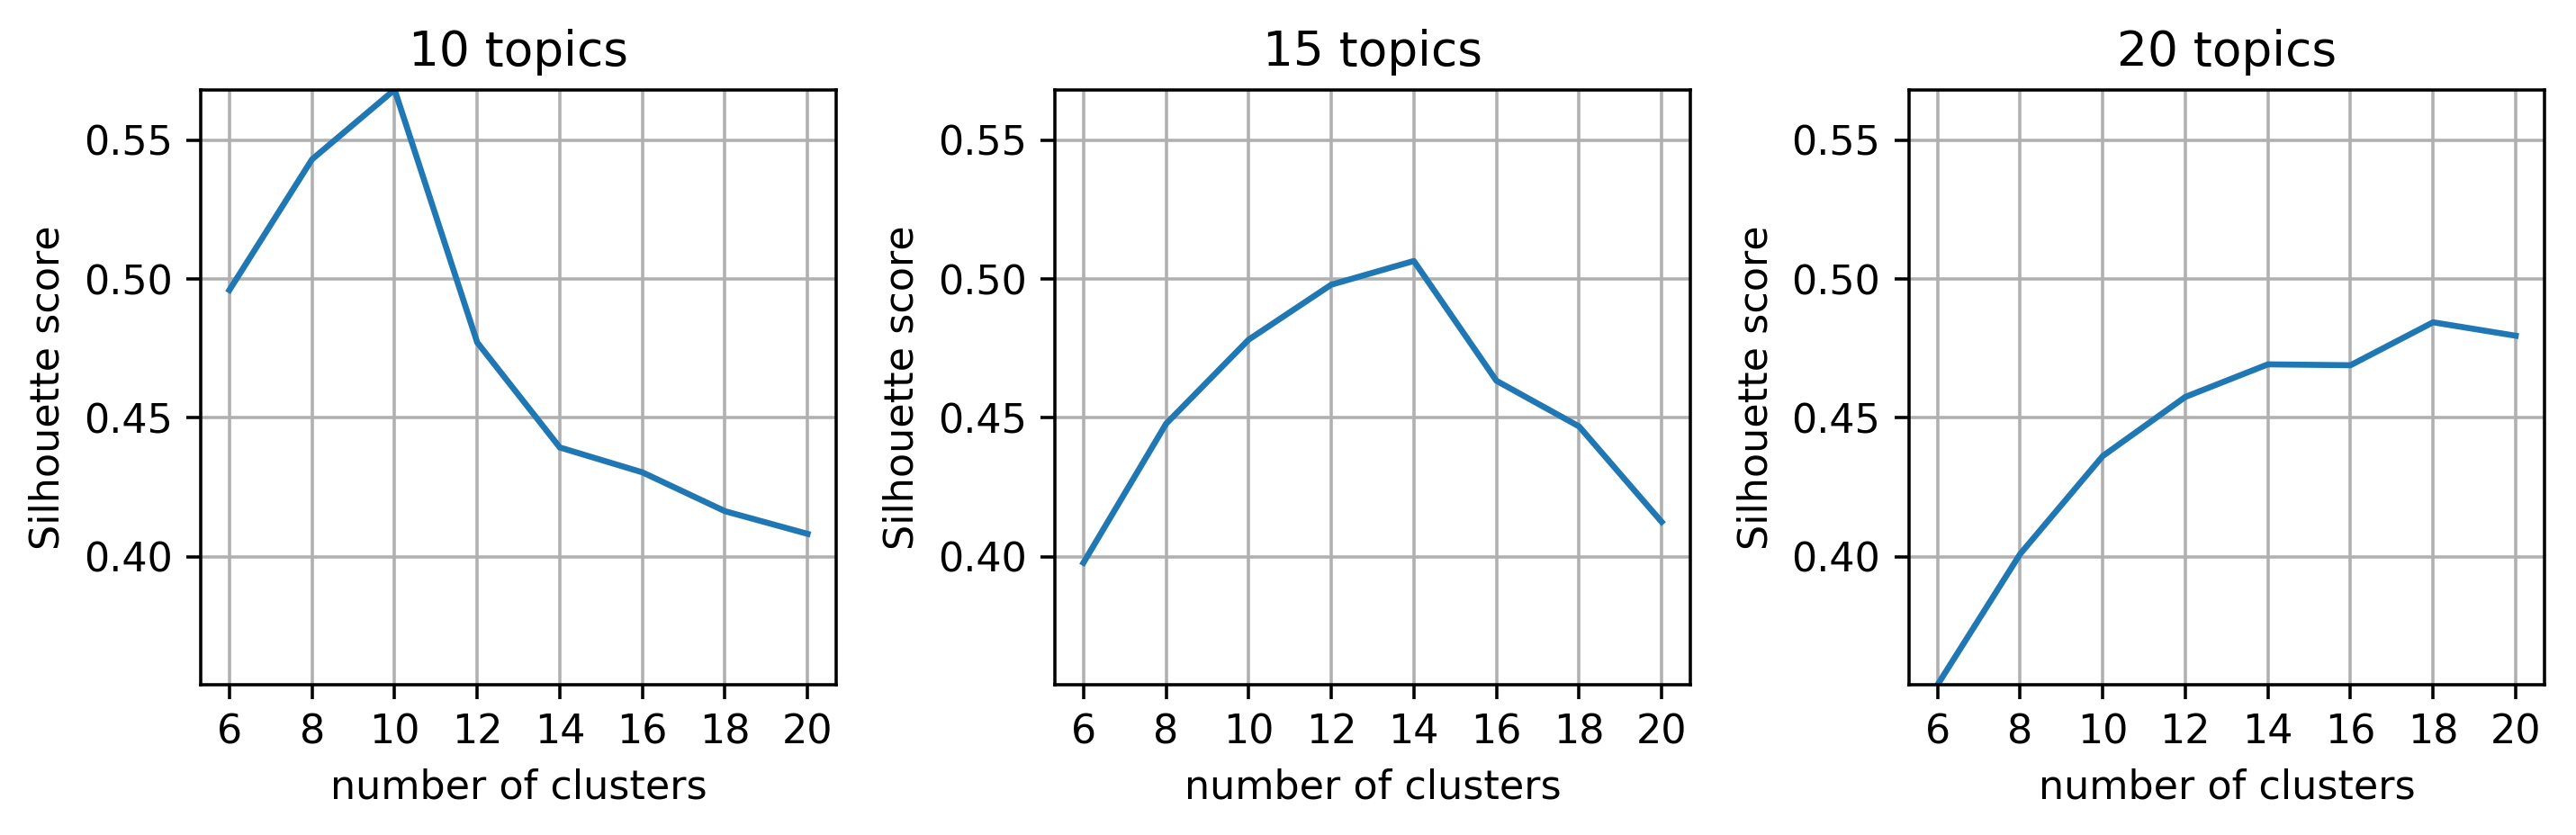

In [13]:
plot_result(all_scores[2], n_clusters_grid, n_topics_grid, 'Spectral')

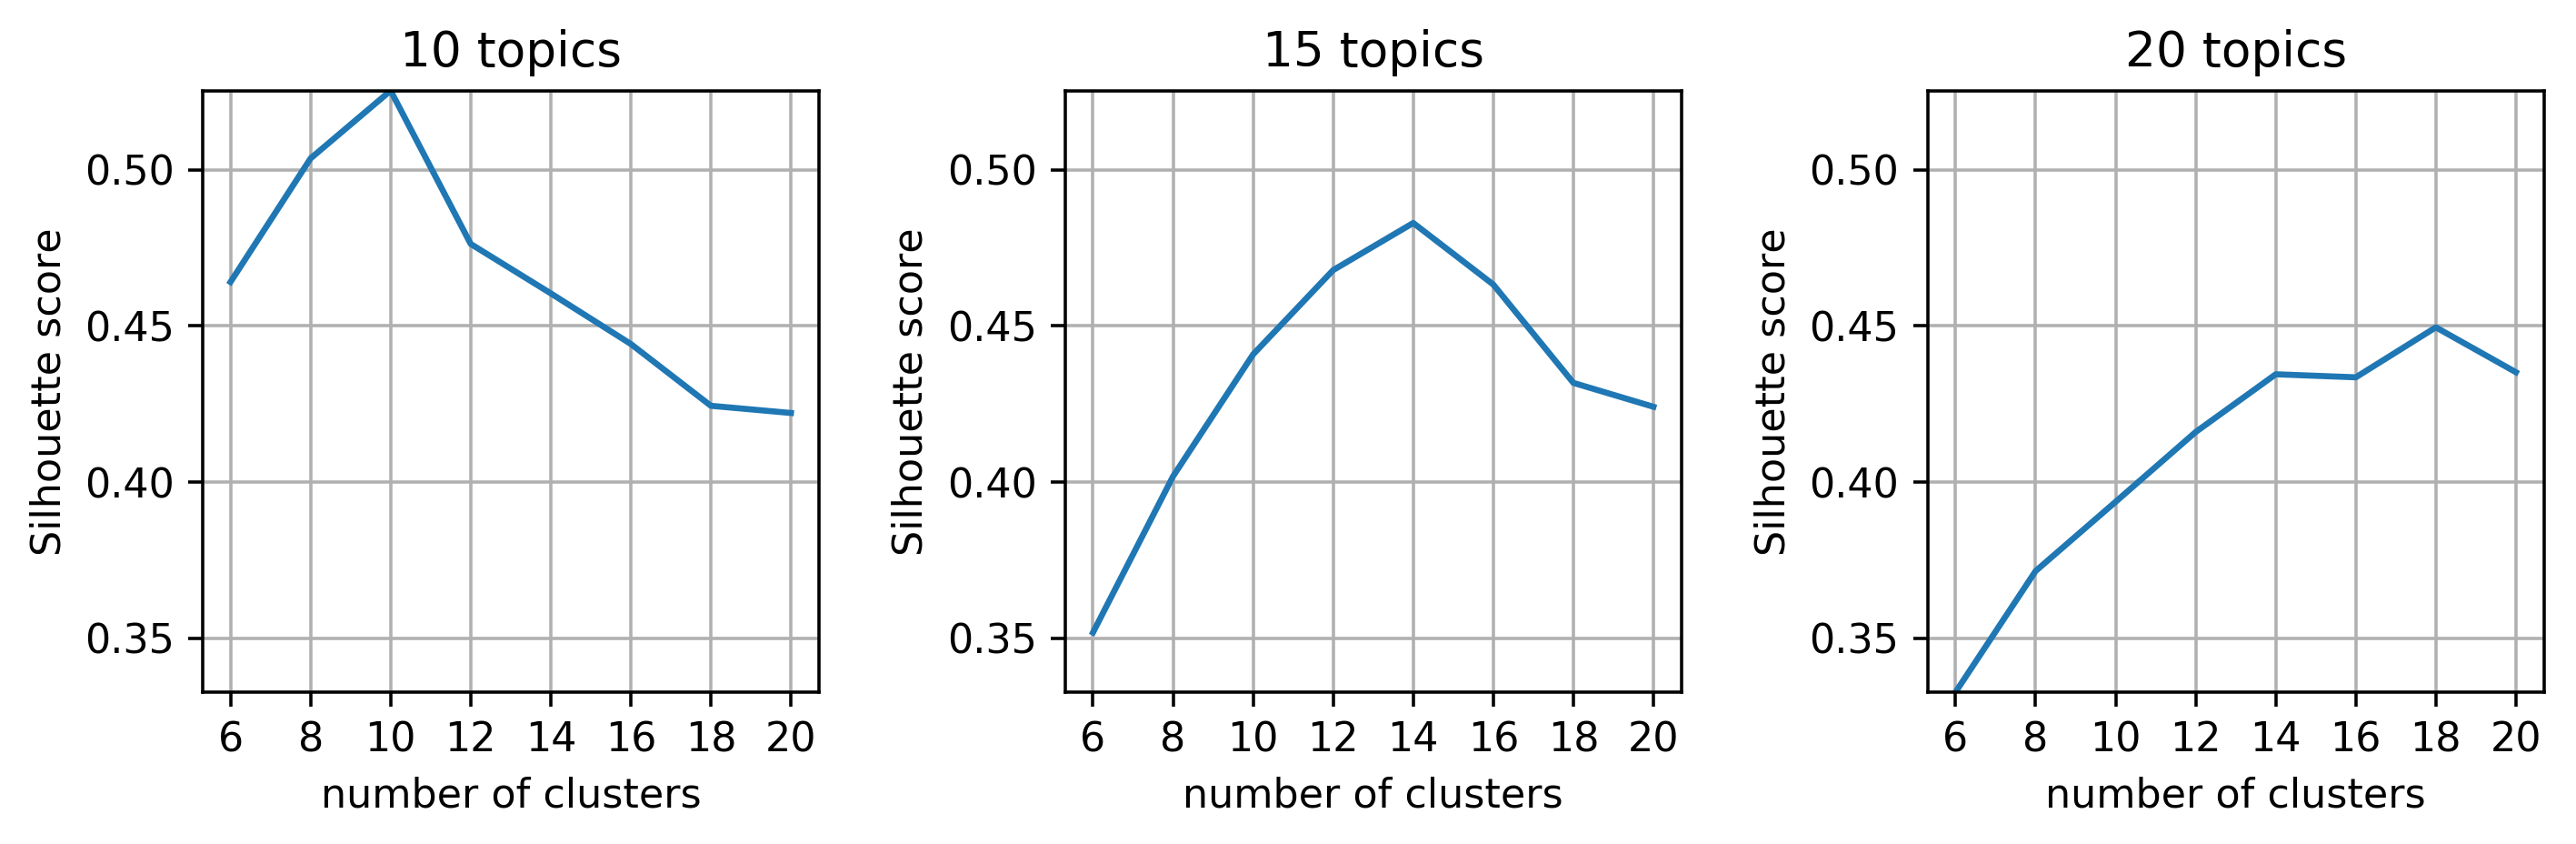

In [14]:
plot_result(all_scores[3], n_clusters_grid, n_topics_grid, 'Agglomerative')

## Now fit the final model

In [9]:
#fit the final model
best_clusters = 10
best_topics = 10
feat_ext, lda = bestLDA(best_config, n_topics=best_topics)
cluster_estimator = KMeans(n_clusters =best_clusters, random_state = 1)

feat_tf = feat_ext.fit_transform(corpus_train)
doc_topic_matrix = lda.fit_transform(feat_tf)
cluster_id = cluster_estimator.fit_predict(doc_topic_matrix)
print ('score from kmeans on train set: {}'.format(silhouette_score(doc_topic_matrix, cluster_id)))

# prediction
feat_test = feat_ext.transform(corpus_test)
test_doc_topic_matrix = lda.transform(feat_test)
test_cluster_id = cluster_estimator.predict(test_doc_topic_matrix)
print('score from kmeans on test set: {}'.format(silhouette_score(test_doc_topic_matrix, test_cluster_id)))

score from kmeans on train set: 0.5808403872018649
score from kmeans on test set: 0.3563940615794706


In [16]:
# write predition result
table_w_tags['cluster_id'] = test_cluster_id
table_w_tags.to_csv('pred_test_cluster.csv')
    

## See what the topics are about

In [10]:
def get_topic_words(model, feature_names, n_top_words):
    topic_words = []
    for topic_idx in range(model.components_.shape[0]):
        message = "Topic {}: ".format(topic_idx+1)
        topic = model.components_[topic_idx,:]
        words = [feature_names[i]
                 for i in topic.argsort()[-n_top_words:][::-1]]
        topic_words.append(words)
    return topic_words    
        
feature_names = feat_ext.get_feature_names()

n_top_words = 10
        
topic_words = get_topic_words(lda, feature_names = feature_names, n_top_words = n_top_words)
for i, words in enumerate(topic_words):
    print("Topic {}, Words: {}".format(i+1, " ".join(words)))

Topic 1, Words: cip cert wne earn bachl pcip assoc count mn userorgroupid
Topic 2, Words: group healthcare provider taxonomy code practice auth mail official bus
Topic 3, Words: post prop evar temp test bfsdev matthias pct virtual trvlr
Topic 4, Words: yr rpy rt store color inventory mdn dv state supp
Topic 5, Words: product type emp code expense topic key warehouse db cloud
Topic 6, Words: col table test pk quarter npt num course db weekday
Topic 7, Words: test code account tableau public type mysql date analytics data
Topic 8, Words: sfdc sobjects createddate createdbyid systemmodstamp lastmodifieddate isdeleted lastmodifiedbyid test status
Topic 9, Words: recruitment teradata retail manufacturing db medium mon chandra test revenue
Topic 10, Words: submission description reason pop currency region test biapp ranking virtual


## see what is the topic distribution for each cluster

In [11]:
# get centroild of in the lda feature space
center_lda_vec = cluster_estimator.cluster_centers_ 
n_cluster = center_lda_vec.shape[0]

n_top_topics = 3

for cluster_idx in range(n_cluster):
    topic_vec = center_lda_vec[cluster_idx,:]
    idx = topic_vec.argsort()[::-1][:n_top_topics]
    print("Cluster {}:".format(cluster_idx+1))
    for i in range(n_top_topics):
        print("Prob {}, Topic {}".format(topic_vec[idx[i]], idx[i]+1))
    print("-"*80)

Cluster 1:
Prob 0.8740421060609107, Topic 2
Prob 0.026824782270946035, Topic 7
Prob 0.02631588807581691, Topic 9
--------------------------------------------------------------------------------
Cluster 2:
Prob 0.8412518484597568, Topic 8
Prob 0.02506128933582654, Topic 4
Prob 0.023672024032827657, Topic 9
--------------------------------------------------------------------------------
Cluster 3:
Prob 0.7579488643899776, Topic 7
Prob 0.04697401448600626, Topic 10
Prob 0.037190751435674935, Topic 5
--------------------------------------------------------------------------------
Cluster 4:
Prob 0.758988298059555, Topic 5
Prob 0.044146362143045174, Topic 2
Prob 0.04290029364909692, Topic 7
--------------------------------------------------------------------------------
Cluster 5:
Prob 0.7724875751946603, Topic 10
Prob 0.054035617991745846, Topic 5
Prob 0.03652716328213551, Topic 8
--------------------------------------------------------------------------------
Cluster 6:
Prob 0.61156142705

In [15]:
center_lda_vec

array([[0.00938125, 0.87404211, 0.00717729, 0.00367695, 0.00809146,
        0.01561107, 0.02682478, 0.00701603, 0.02631589, 0.02186317],
       [0.01765014, 0.00727562, 0.01103929, 0.02506129, 0.01931478,
        0.01952471, 0.02231616, 0.84125185, 0.02367202, 0.01289414],
       [0.01279936, 0.02625005, 0.02438196, 0.0187194 , 0.03719075,
        0.03462188, 0.75794886, 0.01384247, 0.02727124, 0.04697401],
       [0.02138048, 0.04414636, 0.01994621, 0.02477432, 0.7589883 ,
        0.02745686, 0.04290029, 0.02029686, 0.01324405, 0.02686626],
       [0.01516222, 0.02433606, 0.01366211, 0.01980225, 0.05403562,
        0.01714871, 0.03598753, 0.03652716, 0.01085077, 0.77248758],
       [0.06157438, 0.02311232, 0.61156143, 0.03657597, 0.08301537,
        0.01523398, 0.08404435, 0.03835314, 0.02691456, 0.0196145 ],
       [0.02256125, 0.0213334 , 0.01258729, 0.01658482, 0.04687023,
        0.06256455, 0.06442094, 0.07401653, 0.65427891, 0.02478209],
       [0.01562587, 0.0291105 , 0.0078117

## Use T-SNE to visualize the clusters

In [18]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

def get_centroid_words(lda, centroid_vec, feature_names, n_top_words):
    word_prob = np.dot(centroid_vec, lda.components_)
    top_idx = word_prob.argsort()[-n_top_words:][::-1]
    words = [feature_names[i] for i in top_idx]
    return words 

# use word probability to get centroid words
centroid_words = []
for i in range(center_lda_vec.shape[0]):
    centroid_words.append(get_centroid_words(lda, center_lda_vec[i], feature_names, 15))

for i, w in enumerate(centroid_words):
    print('centroid {}: {}'.format(i, w))
    
#concatenate the centroild to doc_topic_matrix for TSNE projection
matrix_w_centroid = np.concatenate((doc_topic_matrix, np.array(center_lda_vec)), axis = 0)

tsne = TSNE(n_components=2, random_state = 2)
tsne_proj = tsne.fit_transform(matrix_w_centroid)

centroid 0: ['group', 'healthcare', 'provider', 'taxonomy', 'code', 'practice', 'auth', 'mail', 'bus', 'official', 'date', 'text', 'npi', 'type', 'phone']
centroid 1: ['sfdc', 'sobjects', 'createddate', 'createdbyid', 'systemmodstamp', 'lastmodifieddate', 'isdeleted', 'lastmodifiedbyid', 'test', 'status', 'cust', 'description', 'parentid', 'type', 'title']
centroid 2: ['test', 'code', 'account', 'type', 'date', 'public', 'tableau', 'mysql', 'analytics', 'data', 'user', 'created', 'apld', 'healthcare', 'amt']
centroid 3: ['product', 'type', 'code', 'emp', 'expense', 'topic', 'db', 'key', 'warehouse', 'cloud', 'position', 'retailer', 'employee', 'organization', 'month']
centroid 4: ['submission', 'description', 'reason', 'test', 'pop', 'currency', 'date', 'region', 'code', 'type', 'healthcare', 'db', 'biapp', 'virtual', 'ranking']
centroid 5: ['post', 'test', 'code', 'prop', 'evar', 'type', 'healthcare', 'product', 'group', 'provider', 'taxonomy', 'temp', 'bfsdev', 'pct', 'matthias']
cen

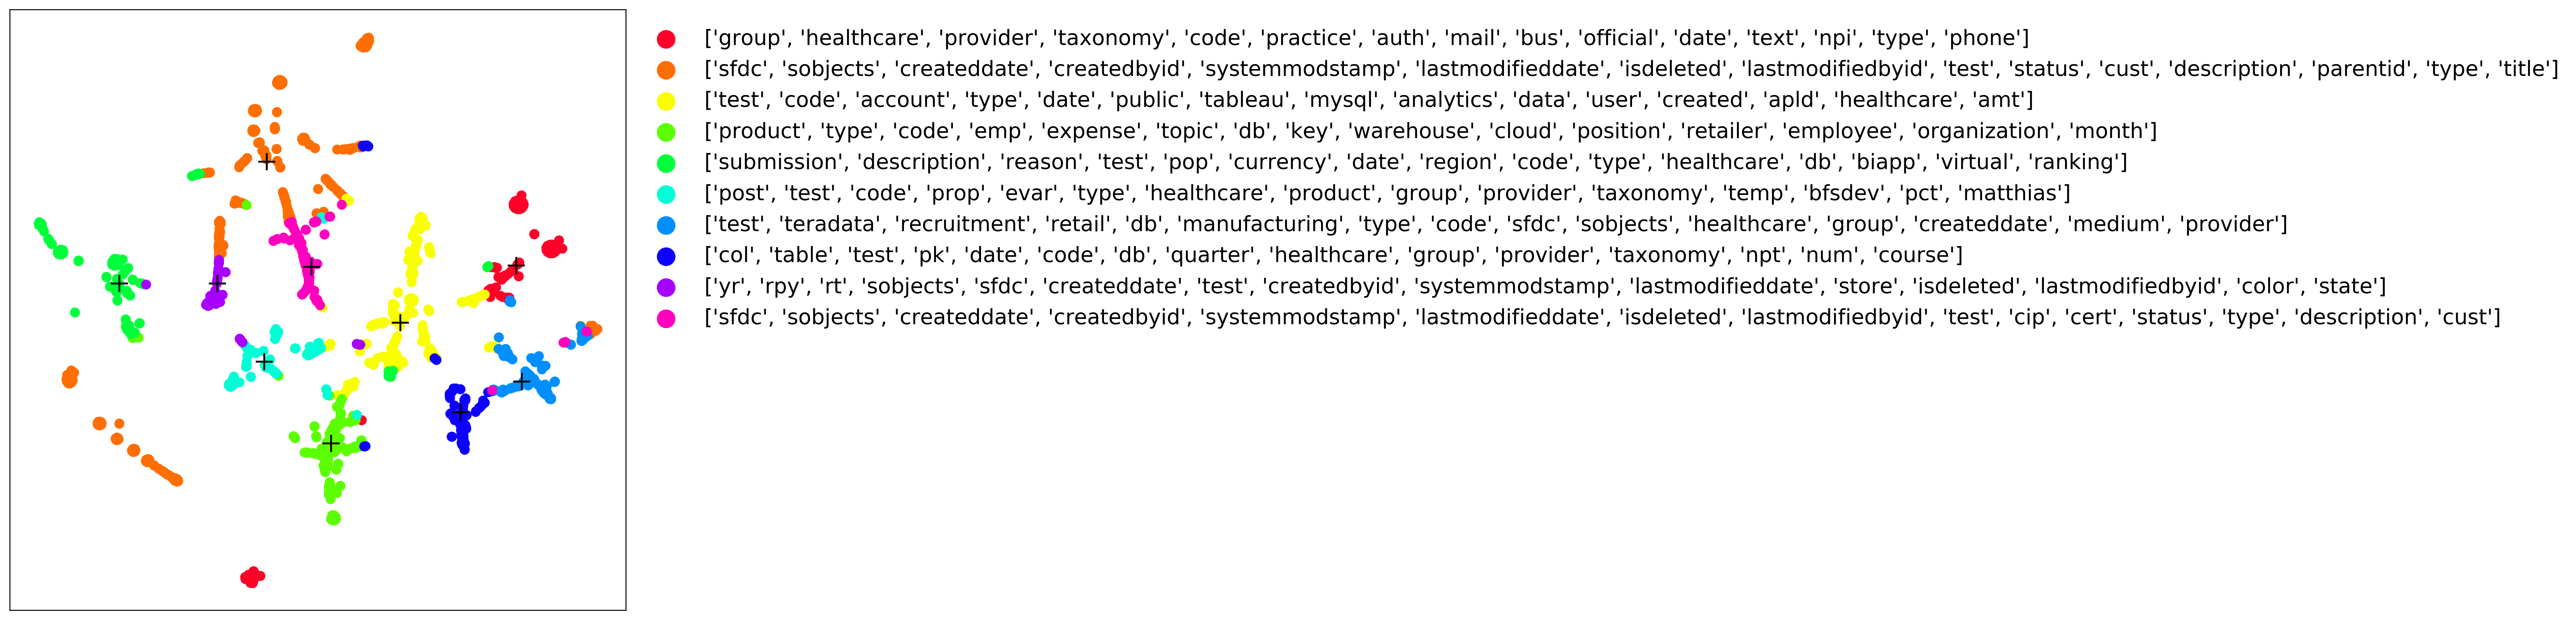

In [19]:
x_main = tsne_proj[:,0][:len(corpus_train)]
y_main = tsne_proj[:,1][:len(corpus_train)]
x_centroid = tsne_proj[:,0][len(corpus_train):]
y_centroid = tsne_proj[:,1][len(corpus_train):]

colorInd = np.linspace(0,1,center_lda_vec.shape[0])

plt.figure(num=None, figsize=(9, 9), dpi=320, facecolor='w', edgecolor='k')
plt.clf()
for cluster_idx in range(center_lda_vec.shape[0]):
    mask = (cluster_id == cluster_idx)
    plt.scatter(x_main[mask], y_main[mask],
               color=matplotlib.cm.gist_rainbow(colorInd[cluster_idx]),
               marker='o',
               s=50,
               label=centroid_words[cluster_idx])


plt.scatter(x_centroid, y_centroid, color= 'black',
                marker = '+', s=200)
plt.xticks([])
plt.yticks([])
plt.legend(loc='best',
           fontsize = 'xx-large', 
            bbox_to_anchor=(1, 1), 
           markerscale = 2,
          fancybox=True, framealpha=0)
plt.show()

## Test result using word vectors which is an independent feature. The idea is that if the clusters are semantically meaningful, the corresponding silhouette score would also be high. In addition, the cosine distance within clusters should be higher than the distance with the total mean.

In [21]:
import spacy
import en_core_web_sm
import en_vectors_glove_md


def word2vector(nlp, list_doc):
    return [nlp(item).vector for item in list_doc]


def cleanup_text(doc_text):
    # replace '_' with space   
    doc_text = re.sub('_', ' ', doc_text)
    # replace digits among strings with space
    doc_text = re.sub(r'[0-9]',' ', doc_text)
    return doc_text.lower()

nlp = spacy.load('en')

# still use 10 words as the topic words
topic_words = get_topic_words(lda, feature_names = feature_names, n_top_words=10)

max_topic_idx = np.argmax(center_lda_vec, axis=1)

# get word vectors for cluster centroids
print("get topic word vectors")
topic_w2v = []
for words in topic_words:
    topic_w2v.append(nlp(" ".join(words)).vector)
topic_w2v = np.vstack(topic_w2v)

print("get centroid word vectors")
centroid_w2v = np.zeros((center_lda_vec.shape[0], topic_w2v.shape[1]))
for i in range(max_topic_idx.shape[0]):
    centroid_w2v[i] = topic_w2v[max_topic_idx[i]]

centroid_w2v /= np.sqrt(np.sum(centroid_w2v**2, axis=1, keepdims=True)+1e-10)

print("get tags word vectors")
# get word vectors for tags
tags = []
for tag in table_w_tags['tags']:
    tags.append(cleanup_text(tag))
tags_w2v = word2vector(nlp, tags)
tags_w2v = np.vstack(tags_w2v)

tags_w2v /= np.sqrt(np.sum(tags_w2v**2, axis=1, keepdims=True)+1e-10)

get topic word vectors
get centroid word vectors
get tags word vectors


In [22]:
# calculate cosine similarities
cosine_sim_centroid = np.dot(tags_w2v, centroid_w2v.T)
cosine_sim_avg = np.dot(tags_w2v, np.mean(centroid_w2v, axis=0))
results = []
pred_cluster_id = np.asarray(table_w_tags['cluster_id'])
for i in range(tags_w2v.shape[0]):
    if cosine_sim_centroid[i, pred_cluster_id[i]] != 0:
        results.append(cosine_sim_centroid[i, pred_cluster_id[i]] > cosine_sim_avg[i])

print(np.mean(results))
within_sim = np.zeros(pred_cluster_id.shape[0])
for i in range(pred_cluster_id.shape[0]):
    within_sim[i] = cosine_sim_centroid[i, pred_cluster_id[i]]
table_w_tags['within_cluster_cosine_sim'] = within_sim
table_w_tags['avg_cluster_cosine_sim'] = cosine_sim_avg
table_w_tags.to_csv('test_cos_result.csv')

0.6153846153846154
